In [1]:
import sys, cv2, os, re, random
sys.path.append('../')

import pandas as pd
from utils import *

## Dataset to DataFrame

In [2]:
dataset_path = "../data/dataset_360/"

In [3]:
images_path = pd.Series(get_files_folder(dataset_path, is_image))
meta_path = images_path.apply(lambda x: x.replace('jpg','txt'))
folds = images_path.apply(lambda x: re.findall('FDDB-fold-\d\d', x)[0])

dict360 = {'image_path':images_path, 'metadata':meta_path, 'fold':folds}
dataset360 = pd.DataFrame(dict360)

In [4]:
dataset360.head()

,image_path,metadata,fold
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01


In [22]:
def get_meta(url):

    with open(url, 'r') as f:
        _ = f.readline()
        phi, theta, r_h = [eval(x) for x in f.readline().rstrip('\n').split(' ')]
        n_faces = int(f.readline().rstrip('\n'))
        faces = []
        for _ in range(n_faces):
            faces.append(eval(f.readline().rstrip('\n')))

        return [phi, theta, r_h, faces]
        

In [23]:
meta = dataset360.metadata.apply(get_meta)

In [26]:
dataset360['phi'] = meta.apply(lambda x: x[0])
dataset360['theta'] = meta.apply(lambda x: x[1])
dataset360['r_h'] = meta.apply(lambda x: x[2])
dataset360['faces'] = meta.apply(lambda x: x[3])

In [27]:
dataset360.head()

,image_path,metadata,fold,phi,theta,r_h,faces
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-35,78,0.994500,"[[(320, 114), (374, 112), (427, 116), (328, 15..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,22,-142,0.523074,"[[(1138, 357), (1152, 357), (1166, 356), (1138..."
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,46,-103,0.695416,"[[(941, 453), (965, 457), (990, 459), (932, 47..."
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-39,-95,0.616609,"[[(940, 144), (975, 143), (1010, 144), (945, 1..."
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,41,132,0.556615,"[[(149, 430), (170, 431), (190, 431), (147, 45..."


In [9]:
def topcenterbottom_to_circular_perimeter(faces):
    n_faces = []
    
    for face in faces:
        t_left, t_center, t_right, c_left, c_right, b_left, b_center, b_right = face
        n_face = [t_left, t_center, t_right, c_right, b_right, b_center, b_left, c_left]
        n_faces.append(n_face)
    return n_faces

In [15]:
circular_perimeter_faces = dataset360.faces.apply(topcenterbottom_to_circular_perimeter)
dataset360['circular_perimeter_faces'] = circular_perimeter_faces
dataset360.head()

,image_path,metadata,fold,phi,theta,r_h,faces,circular_perimeter_faces
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-35,78,0.994500,"[[(320, 114), (374, 112), (427, 116), (328, 15...","[[(320, 114), (374, 112), (427, 116), (415, 15..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,22,-142,0.523074,"[[(1138, 357), (1152, 357), (1166, 356), (1138...","[[(1138, 357), (1152, 357), (1166, 356), (1167..."
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,46,-103,0.695416,"[[(941, 453), (965, 457), (990, 459), (932, 47...","[[(941, 453), (965, 457), (990, 459), (988, 48..."
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-39,-95,0.616609,"[[(940, 144), (975, 143), (1010, 144), (945, 1...","[[(940, 144), (975, 143), (1010, 144), (1006, ..."
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,41,132,0.556615,"[[(149, 430), (170, 431), (190, 431), (147, 45...","[[(149, 430), (170, 431), (190, 431), (192, 45..."


In [16]:
dataset360.to_pickle('../dataframes/dataset360.pkl')

## Dataset Analysis

In [17]:
dataset360 = pd.read_pickle('../dataframes/dataset360.pkl')

In [18]:
dataset360.head()

,image_path,metadata,fold,phi,theta,r_h,faces,circular_perimeter_faces
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-35,78,0.994500,"[[(320, 114), (374, 112), (427, 116), (328, 15...","[[(320, 114), (374, 112), (427, 116), (415, 15..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,22,-142,0.523074,"[[(1138, 357), (1152, 357), (1166, 356), (1138...","[[(1138, 357), (1152, 357), (1166, 356), (1167..."
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,46,-103,0.695416,"[[(941, 453), (965, 457), (990, 459), (932, 47...","[[(941, 453), (965, 457), (990, 459), (988, 48..."
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-39,-95,0.616609,"[[(940, 144), (975, 143), (1010, 144), (945, 1...","[[(940, 144), (975, 143), (1010, 144), (1006, ..."
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,41,132,0.556615,"[[(149, 430), (170, 431), (190, 431), (147, 45...","[[(149, 430), (170, 431), (190, 431), (192, 45..."


<AxesSubplot:title={'center':'phi distribution'}, ylabel='Frequency'>

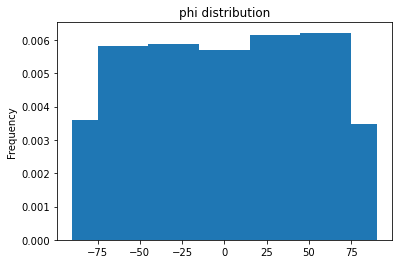

In [19]:
dataset360.phi.plot.hist(bins=[-90, -75, -45, -15, 15, 45, 75, 90], title = 'phi distribution', density = True)

<AxesSubplot:title={'center':'theta distribution'}, ylabel='Frequency'>

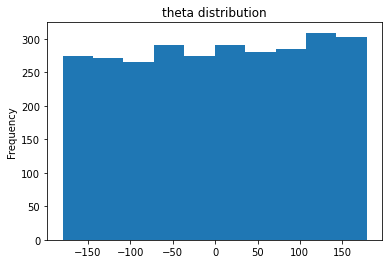

In [20]:
dataset360.theta.plot.hist(title = 'theta distribution')

<AxesSubplot:title={'center':'r_h distribution'}, ylabel='Frequency'>

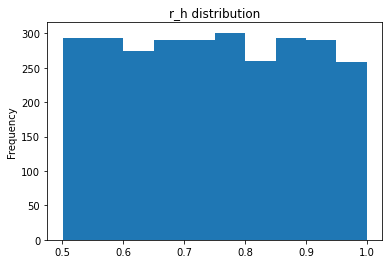

In [21]:
dataset360.r_h.plot.hist(title = 'r_h distribution')

<AxesSubplot:>

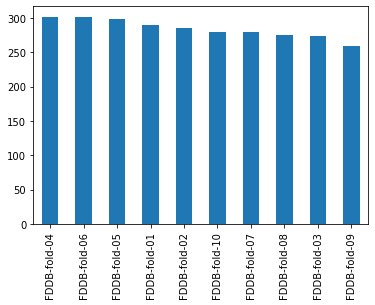

In [22]:
dataset360.fold.value_counts().plot.bar()

## Display Dataset

In [23]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from equi_augmentation import *
figsize(5, 5)

In [24]:
dataset360 = pd.read_pickle('../dataframes/dataset360.pkl')

In [25]:
sample = dataset360.iloc[np.random.randint(dataset360.shape[0])]

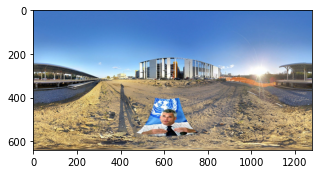

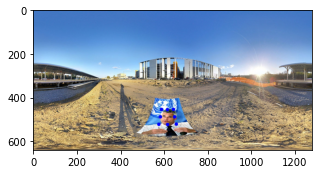

In [26]:
im = cv2.imread(sample.image_path)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
for face_points in sample.faces:
    im = draw_points(im, face_points, color = (255,0,0))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()